In [1]:
# Cell 1: Imports, Seed & Device Setup
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image

# Reproducibility extremely random
# Seed for reproducibility
# Set the random seed for all libraries
seed = 6784
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Hyperparameters & DataLoader
latent_dim  = 100    # size of z noise vector
batch_size  = 64     # training batch size
image_size  = 128    # resolution of images (128×128)
epochs      = 20    # total epochs
n_g_steps   = 3      # G updates per D update

# Transform pipeline
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

class customDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0

# Point to your folder of friend‑face images
data_path = "./anime"
if not os.path.isdir(data_path):
    raise FileNotFoundError(f"Folder not found: {data_path}")

dataset = customDataset(root_dir=data_path, transform=transform)
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                     num_workers=4, pin_memory=True)

In [3]:
# Cell 3: Generator & Discriminator Definitions
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # input Z: (latent_dim ×1×1)
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            # 512×4×4 → 256×8×8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            # 256×8×8 → 128×16×16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            # 128×16×16 → 64×32×32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            # 64×32×32 → 32×64×64
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(True),
            # 32×64×64 → 3×128×128
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 3×128×128 → 64×64×64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64×64×64 → 128×32×32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            # 128×32×32 → 256×16×16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            # 256×16×16 → 512×8×8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            # 512×8×8 → 1×1×1
            nn.Conv2d(512, 1, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)

In [4]:
# Cell 4: Model Instantiation, Optimizers, Loss
G    = Generator().to(device)
D    = Discriminator().to(device)
optG = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=5e-5, betas=(0.5, 0.999))
criterion = nn.BCELoss()

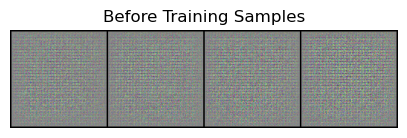

[1/20]  Loss_D: 0.8146  Loss_G: 1.7838  RealAcc: 0.51  FakeAcc: 0.65


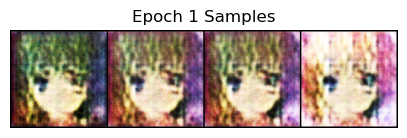

[2/20]  Loss_D: 0.7885  Loss_G: 0.8788  RealAcc: 0.21  FakeAcc: 0.50


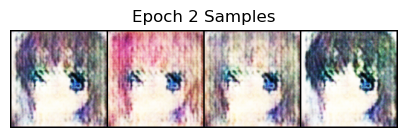

[3/20]  Loss_D: 0.7699  Loss_G: 0.8105  RealAcc: 0.15  FakeAcc: 0.53


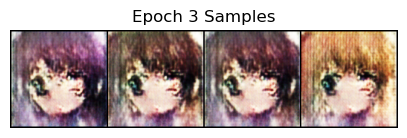

[4/20]  Loss_D: 0.7558  Loss_G: 0.8353  RealAcc: 0.16  FakeAcc: 0.59


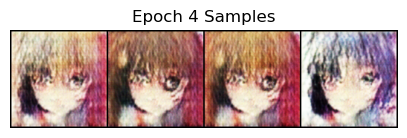

[5/20]  Loss_D: 0.7442  Loss_G: 0.8484  RealAcc: 0.19  FakeAcc: 0.63


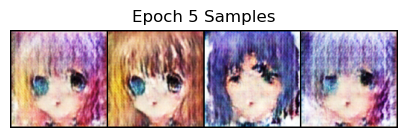

[6/20]  Loss_D: 0.7270  Loss_G: 0.9454  RealAcc: 0.29  FakeAcc: 0.66


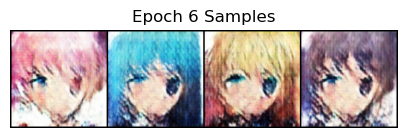

[7/20]  Loss_D: 0.7022  Loss_G: 1.0235  RealAcc: 0.38  FakeAcc: 0.71


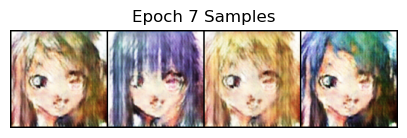

[8/20]  Loss_D: 0.6695  Loss_G: 1.1792  RealAcc: 0.47  FakeAcc: 0.75


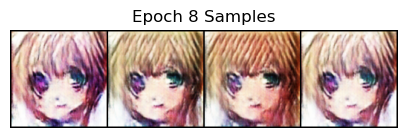

[9/20]  Loss_D: 0.6475  Loss_G: 1.2550  RealAcc: 0.52  FakeAcc: 0.78


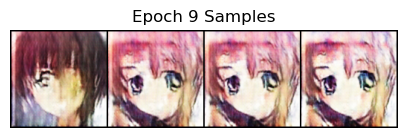

[10/20]  Loss_D: 0.6243  Loss_G: 1.3466  RealAcc: 0.56  FakeAcc: 0.80


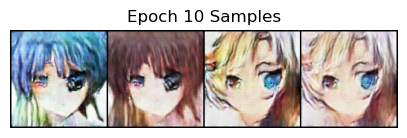

[11/20]  Loss_D: 0.6148  Loss_G: 1.3675  RealAcc: 0.57  FakeAcc: 0.80


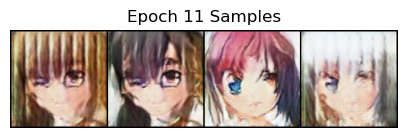

[12/20]  Loss_D: 0.5798  Loss_G: 1.4804  RealAcc: 0.62  FakeAcc: 0.84


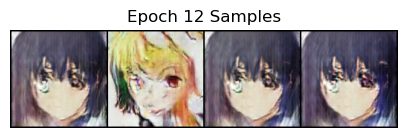

[13/20]  Loss_D: 0.5263  Loss_G: 1.7077  RealAcc: 0.68  FakeAcc: 0.88


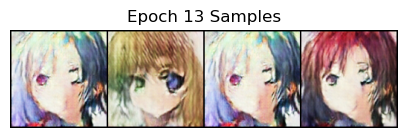

[14/20]  Loss_D: 0.4897  Loss_G: 1.8434  RealAcc: 0.72  FakeAcc: 0.90


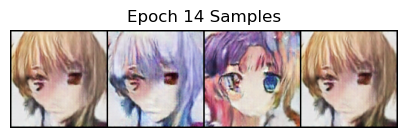

[15/20]  Loss_D: 0.4546  Loss_G: 1.9867  RealAcc: 0.75  FakeAcc: 0.92


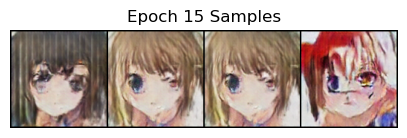

[16/20]  Loss_D: 0.4018  Loss_G: 2.1574  RealAcc: 0.80  FakeAcc: 0.95


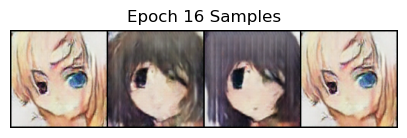

[17/20]  Loss_D: 0.3506  Loss_G: 2.4964  RealAcc: 0.84  FakeAcc: 0.97


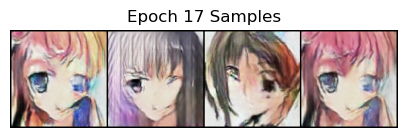

[18/20]  Loss_D: 0.3219  Loss_G: 2.6592  RealAcc: 0.86  FakeAcc: 0.98


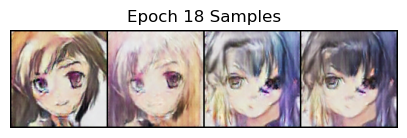

[19/20]  Loss_D: 0.2991  Loss_G: 2.9245  RealAcc: 0.88  FakeAcc: 0.98


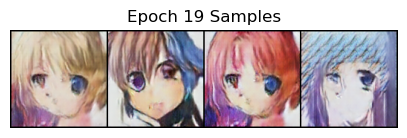

[20/20]  Loss_D: 0.2842  Loss_G: 3.0459  RealAcc: 0.89  FakeAcc: 0.99


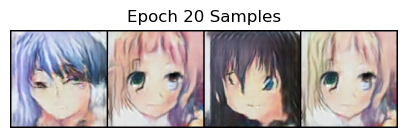

In [5]:
# Cell 5: Training Loop

G.eval()
with torch.no_grad():
    z = torch.randn(4, latent_dim, 1, 1, device=device)
    samples = G(z).cpu()
grid = vutils.make_grid(samples, nrow=4, normalize=True)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.title(f"Before Training Samples")
plt.imshow(grid.permute(1,2,0))
plt.show()
plt.close()

history = {'lossD': [], 'lossG': [], 'real_acc': [], 'fake_acc': []}

for ep in range(1, epochs+1):
    G.train(); D.train()
    sumD = sumG = accR = accF = 0.0
    batches = 0

    for real_imgs, _ in loader:
        real_imgs = real_imgs.to(device)
        b = real_imgs.size(0)
        # Label smoothing + jitter
        valid = (torch.full((b,), 0.9, device=device)
                 + 0.05*torch.rand(b, device=device)).clamp(0,1)
        fake = torch.zeros(b, device=device)

        # —— Train Discriminator ——
        optD.zero_grad()
        # Real
        predR = D(real_imgs)
        lossR = criterion(predR, valid)
        # Fake
        z = torch.randn(b, latent_dim, 1, 1, device=device)
        fake_imgs = G(z).detach()
        predF = D(fake_imgs)
        lossF = criterion(predF, fake)
        # Accuracy
        accR += (predR > 0.5).float().mean().item()
        accF += (predF < 0.5).float().mean().item()
        # Backprop D
        lossD = 0.5*(lossR + lossF)
        lossD.backward()
        optD.step()

        # —— Train Generator (n_g_steps) ——
        g_loss_total = 0.0
        for _ in range(n_g_steps):
            optG.zero_grad()
            z = torch.randn(b, latent_dim, 1, 1, device=device)
            gen = G(z)
            pred = D(gen)
            lossG = criterion(pred, valid)
            lossG.backward()
            optG.step()
            g_loss_total += lossG.item()

        # Accumulate stats
        sumD += lossD.item()
        sumG += (g_loss_total / n_g_steps)
        batches += 1

    # Record epoch means
    history['lossD'].append(sumD / batches)
    history['lossG'].append(sumG / batches)
    history['real_acc'].append(accR / batches)
    history['fake_acc'].append(accF / batches)

    # Print progress
    print(f"[{ep}/{epochs}]  Loss_D: {history['lossD'][-1]:.4f}  "
          f"Loss_G: {history['lossG'][-1]:.4f}  "
          f"RealAcc: {history['real_acc'][-1]:.2f}  "
          f"FakeAcc: {history['fake_acc'][-1]:.2f}")

    # Sample visuals every 10 epochs
    if ep % 1 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(4, latent_dim, 1, 1, device=device)
            samples = G(z).cpu()
        grid = vutils.make_grid(samples, nrow=4, normalize=True)
        plt.figure(figsize=(5,5))
        plt.axis('off')
        plt.title(f"Epoch {ep} Samples")
        plt.imshow(grid.permute(1,2,0))
        plt.show()
        plt.close()


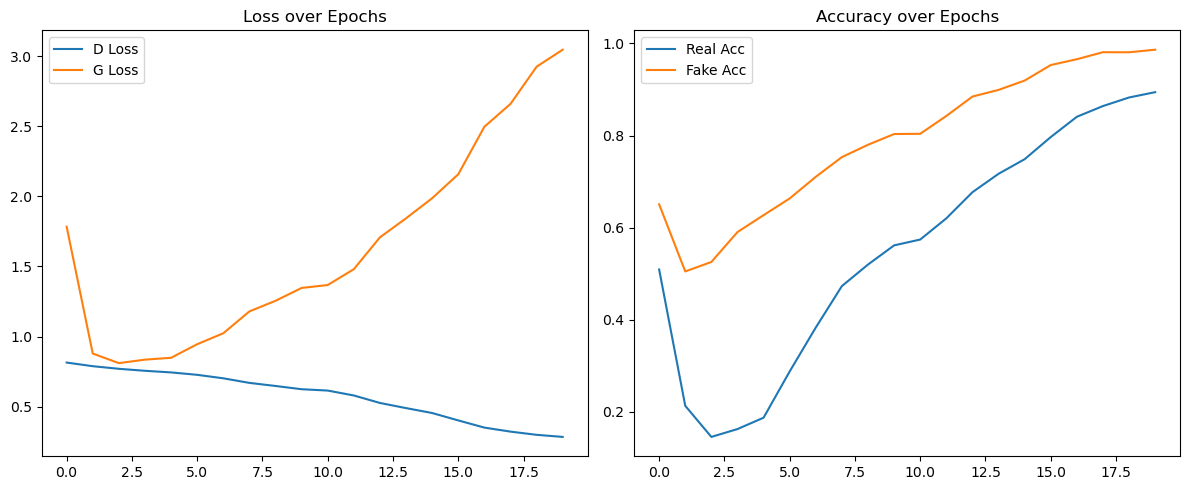

In [6]:
# Cell 6: Plot Training Curves
plt.figure(figsize=(12,5))
# Loss
plt.subplot(1,2,1)
plt.plot(history['lossD'], label='D Loss')
plt.plot(history['lossG'], label='G Loss')
plt.title("Loss over Epochs"); plt.legend()
# Accuracy
plt.subplot(1,2,2)
plt.plot(history['real_acc'], label='Real Acc')
plt.plot(history['fake_acc'], label='Fake Acc')
plt.title("Accuracy over Epochs"); plt.legend()
plt.tight_layout()
plt.show()
plt.close()


In [7]:
# Cell 7: Save Final Models
# Ensure CUDA ops complete
if device.type == "cuda":
    torch.cuda.synchronize()
torch.save(G.state_dict(), "dcgan-anime-generator.pth")
torch.save(D.state_dict(), "dcgan-anime-discriminator.pth")
print("Saved generator & discriminator!")


Saved generator & discriminator!
